In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
%matplotlib inline

Load in all well data

In [2]:
data = pd.read_csv(r'../data/all_wells.csv')
data.head()

,easting,northing,porosity,permeability,Poisson's ratio,Young's Modulus,water saturation,oil saturation,proppant weight (lbs),pump rate (cubic feet/min),...,water 3,water 4,water 5,water 6,water 7,water 8,water 9,water 10,water 11,water 12
0,6300.0,53700.0,0.05,0.009,0.305,1.058935e+07,0.118212,0.881788,870417.418369,393.486280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6401.0,53700.0,0.03,0.004,0.305,1.059206e+07,0.117850,0.882150,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6502.0,53700.0,0.05,0.008,0.305,1.059487e+07,0.117492,0.882508,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6602.0,53700.0,0.03,0.003,0.305,1.059776e+07,0.117138,0.882862,860887.258744,278.775058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6703.0,53700.0,0.03,0.003,0.304,1.060074e+07,0.116788,0.883212,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Add new columns that are the square of the 'easting' and 'northing' features. These might be helpful for our neural network.

In [27]:
data['easting squared'] = data['easting'] ** 2
data['northing squared'] = data['northing'] ** 2
data.head()

,easting,northing,porosity,permeability,Poisson's ratio,Young's Modulus,water saturation,oil saturation,proppant weight (lbs),pump rate (cubic feet/min),...,water 5,water 6,water 7,water 8,water 9,water 10,water 11,water 12,easting squared,northing squared
0,6300.0,53700.0,0.05,0.009,0.305,1.058935e+07,0.118212,0.881788,870417.418369,393.486280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39690000.0,2.883690e+09
1,6401.0,53700.0,0.03,0.004,0.305,1.059206e+07,0.117850,0.882150,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40972801.0,2.883690e+09
2,6502.0,53700.0,0.05,0.008,0.305,1.059487e+07,0.117492,0.882508,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42276004.0,2.883690e+09
3,6602.0,53700.0,0.03,0.003,0.305,1.059776e+07,0.117138,0.882862,860887.258744,278.775058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43586404.0,2.883690e+09
4,6703.0,53700.0,0.03,0.003,0.304,1.060074e+07,0.116788,0.883212,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44930209.0,2.883690e+09


Initialize our scaler

In [3]:
min_max_scaler = preprocessing.MinMaxScaler()

Build testing and training datasets

In [28]:
def build_datasets(predictors, target, test_size=0.8, random_state=0):
    total_data = data[predictors + [target]].dropna()
    scaled_x = pd.DataFrame(min_max_scaler.fit_transform(total_data[predictors]))
    scaled_y = pd.DataFrame(min_max_scaler.fit_transform(total_data[target].values.reshape(-1, 1)))
    train_x, test_x, train_y, test_y = train_test_split(scaled_x, scaled_y, test_size=test_size, random_state=random_state)
    
    train = torch.utils.data.TensorDataset(torch.Tensor(np.array(train_x)), torch.Tensor(np.array(train_y)))
    train_loader = torch.utils.data.DataLoader(train, batch_size = 64, shuffle = True)
    
    return (train_loader, test_x, test_y)

In [5]:
def train_model(model, optimizer, train_loader, criterion=nn.SmoothL1Loss(), epochs=100):
    for e in range(epochs):
        running_loss = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            forward_pass = model(features)
            loss = criterion(forward_pass, labels.type(torch.FloatTensor))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if (e + 1) % (epochs // 10) == 0:
            print("===================== Epoch %d =====================" % (e + 1))
            print("Training loss: %.10f" % (running_loss / len(train_loader)))

In [39]:
def plot_feature(model, feature, precision=2000):
    easting = data['easting']
    northing = data['northing']
    grid = np.mgrid[easting.min():easting.max():precision, northing.min():northing.max():precision]
    grid = grid.reshape((2, -1))

    input_array = []

    for i in range(len(grid[0])):
        input_array.append((grid[0][i], grid[1][i], grid[0][i] ** 2, grid[1][i] ** 2))

    with torch.no_grad():
        features = torch.tensor(min_max_scaler.fit_transform(np.array(input_array))).float();
        predictions = min_max_scaler.fit_transform(model(features))[:, 0]

        plt.xlabel('easting')
        plt.ylabel('northing')
        plt.scatter(grid[0], grid[1], c=predictions)
        plt.colorbar()

In [7]:
def score_model(model, test_x, test_y):
    with torch.no_grad():
        predictions = model(torch.tensor(np.array(test_x)).float())
        print(r2_score(predictions, test_y))

In [62]:
model = nn.Sequential(nn.Linear(4, 6),
                      nn.ReLU(),
                      nn.Linear(6, 6),
                      nn.ReLU(),
                      nn.Linear(6, 6),
                      nn.ReLU(),
                      nn.Linear(6, 6),
                      nn.ReLU(),
                      nn.Linear(6, 6),
                      nn.ReLU(),
                      nn.Linear(6, 1),
                     )

predictors = ['easting', 'northing', 'easting squared', 'northing squared']
target = 'porosity'
train_loader, test_x, test_y = build_datasets(predictors, target)

In [63]:
train_model(model, optim.SGD(model.parameters(), lr=0.1), train_loader, epochs=1000)

===================== Epoch 100 =====================
Training loss: 0.0073912608
===================== Epoch 200 =====================
Training loss: 0.0060245043
===================== Epoch 300 =====================
Training loss: 0.0059432198
===================== Epoch 400 =====================
Training loss: 0.0059673321
===================== Epoch 500 =====================
Training loss: 0.0059644435
===================== Epoch 600 =====================
Training loss: 0.0057692824
===================== Epoch 700 =====================
Training loss: 0.0059192940
===================== Epoch 800 =====================
Training loss: 0.0058084890
===================== Epoch 900 =====================
Training loss: 0.0058579929
===================== Epoch 1000 =====================
Training loss: 0.0058573541


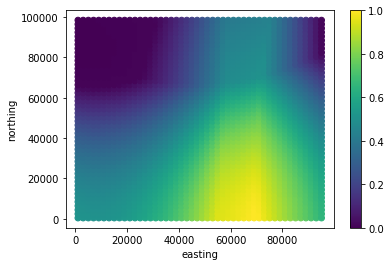

In [64]:
plot_feature(model, 'porosity')

In [65]:
score_model(model, test_x, test_y)

0.5877628671947879
